## Run The Circuit on a Quantum Provider

#### Build The time dependent Hamiltonian

Imports and Routines

In [20]:
import qiskit
import numpy as np
from qiskit.quantum_info import SparsePauliOp

from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from typing import Dict



def get_hamiltonian(t_onebody:Dict, n_sites:int):

    # List of Hamiltonian terms as 3-tuples containing
    # (1) the Pauli string,
    # (2) the qubit indices corresponding to the Pauli string,
    # (3) the coefficient.
    XX_tuples=[]
    YY_tuples=[]
    Z_tuples=[]
    I_tuples=[]
    for (i,j),t_val in t_onebody.items():
    
        if i==j:
            Z_tuples.append(("Z", [i], -0.5*t_val))
            I_tuples.append(('I',[i],0.5*t_val)) 
        else:
            XX_tuples.append( ("XX", [i, j], 0.5*t_val) )
            YY_tuples.append(("YY", [i, j], 0.5*t_val) )
            
    # We create the Hamiltonian as a SparsePauliOp, via the method
    # `from_sparse_list`, and multiply by the interaction term.
    hamiltonian = SparsePauliOp.from_sparse_list([*XX_tuples, *YY_tuples,*Z_tuples,*I_tuples], num_qubits=n_sites)
    return hamiltonian.simplify()


Loading the parameters of $H_Q$

In [65]:
data_onebody=np.load('data/matrix_elements_h_eff_2body/one_body_nn_p.npz')
keys=data_onebody['keys']
values=data_onebody['values']
n_qubits=3

t_onebody={}

for a,key in enumerate(keys):
    i,j=key
    t_onebody[(i,j)]=values[a]
    
print(t_onebody)

t_onebody.pop((0,1))
t_onebody.pop((0,2))
t_onebody.pop((1,2))

print(t_onebody)

{(0, 0): -26.722099999999998, (0, 1): 1.0430999999999995, (0, 2): -3.763858685577873, (1, 0): 1.0430999999999995, (1, 1): -26.722099999999998, (1, 2): 3.763858685577873, (2, 0): -3.763858685577873, (2, 1): 3.763858685577873, (2, 2): -23.4103}
{(0, 0): -26.722099999999998, (1, 0): 1.0430999999999995, (1, 1): -26.722099999999998, (2, 0): -3.763858685577873, (2, 1): 3.763858685577873, (2, 2): -23.4103}


Compute $H_Q$

In [22]:
hamiltonian_q=get_hamiltonian(t_onebody=t_onebody,n_sites=n_qubits)

Compute $H_D$

In [23]:
coupling_term=-26.7221
Z_tuples=[("Z", [0], -0.5*coupling_term)]
I_tuples=[('I',[0],0.5*coupling_term)]

        
# We create the Hamiltonian as a SparsePauliOp, via the method
# `from_sparse_list`, and multiply by the interaction term.
hamiltonian_driver = SparsePauliOp.from_sparse_list([*Z_tuples,*I_tuples], num_qubits=n_qubits)


#### Build the circuit

In [73]:
from qiskit.quantum_info import SparsePauliOp
from qiskit.synthesis import SuzukiTrotter,QDrift
from qiskit.circuit.library import PauliEvolutionGate
from qiskit import transpile
from qiskit.quantum_info import Statevector

#final_state=Statevector(circuit_opt)
time_steps=100
tf=10
time=np.linspace(0,tf,time_steps)
dt=tf/time_steps
#b=0.8
#h=1-(1+b)*(time/tf)+b*(time/tf)**2
h=1-time/tf
circuit_time_evolution=QuantumCircuit(hamiltonian_q.num_qubits,hamiltonian_q.num_qubits)
circuit_time_evolution.x([0]) # initial state

energies_qiskit=np.zeros((time_steps))


for n,t in enumerate(time):
    hamiltonian_t=((h[n])*hamiltonian_driver+(1-h[n])*hamiltonian_q)
    exp_H_t=PauliEvolutionGate(hamiltonian_t,time=dt,synthesis=SuzukiTrotter(order=1))
    circuit_time_evolution.append(exp_H_t,range(hamiltonian_q.num_qubits))
    single_particle_vector=np.zeros(2**n_qubits,dtype=np.complex128)
    psi_for_fidelity=np.zeros(n_qubits,dtype=np.complex128)
    # for a in range(n_qubits):
    #     a_mb=2**(a)
    #     final_state=Statevector(circuit_time_evolution).data
    #     single_particle_vector[a_mb]=final_state[a_mb]
    #     psi_for_fidelity[a]=final_state[a_mb]
    # energies_qiskit[n]=Statevector(single_particle_vector).expectation_value(hamiltonian_t)
print(Statevector(circuit_time_evolution).expectation_value(hamiltonian_q))
transpiled_circuit_time_evolution=transpile(circuit_time_evolution.decompose(), optimization_level=3,basis_gates=['cx','s','h','rz','x'])

(-31.334163248207602+0j)


In [ ]:
transpiled_circuit_time_evolution.draw()

#### Perform Measurement Shots using an IBM clean backend

In [7]:
z_measure_QA_circuit=transpiled_circuit_time_evolution.copy()
z_measure_QA_circuit.measure([0, 1, 2], [0, 1, 2])
z_measure_QA_circuit.measure_all()



#### Classical Backend

In [105]:
print(hamiltonian_q.to_list())

[('IXX', (0.5215499999999997+0j)), ('XIX', (-1.8819293427889365+0j)), ('XXI', (1.8819293427889365+0j)), ('IYY', (0.5215499999999997+0j)), ('YIY', (-1.8819293427889365+0j)), ('YYI', (1.8819293427889365+0j)), ('IIZ', (13.361049999999999+0j)), ('IZI', (13.361049999999999+0j)), ('ZII', (11.70515+0j)), ('III', (-38.42725+0j))]


In [106]:
from qiskit_ibm_provider import IBMProvider
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke,FakeMarrakesh
from qiskit_aer import StatevectorSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
# Replace with your actual API token
# service = IBMProvider(token='91830ee51d4a39179a63363dd51d2b588653b869a4cab814c29deb5ac3ded710d02c63902e330e53bbfb36994a605f76f6822b3e608a78b38cc8927e023b0ea9')
# backends = service.backends()
# for backend in backends:
#     print(backend.name)
    

    
# # Load the service
# #service = QiskitRuntimeService(token='91830ee51d4a39179a63363dd51d2b588653b869a4cab814c29deb5ac3ded710d02c63902e330e53bbfb36994a605f76f6822b3e608a78b38cc8927e023b0ea9')
backend = FakeMarrakesh()
# backend = service.get_backend("ibm_brisbane")

# service = QiskitRuntimeService()
# backend = service.least_busy(
#     operational=True, simulator=False, min_num_qubits=127
# )

# print(backend)
#backend=StatevectorSimulator()
 
estimator = Estimator(mode=backend)
options = estimator.options
# Turn on gate twirling.
options.twirling.enable_gates = True
options.twirling.num_randomizations = 60
options.twirling.shots_per_randomization = 100
options.resilience.pec_mitigation = True
options.resilience.pec_mitigation = True
# #options.resilience.pec.max_overhead = 300
options.dynamical_decoupling.enable = True
options.dynamical_decoupling.sequence_type = "XpXm"

# options.resilience.zne_mitigation = True
# options.resilience.zne.noise_factors = (1, 2, 3,4,5,6)
# options.resilience.zne.extrapolator = "exponential"
# estimator.options.resilience.zne.amplifier = "pea"


pm = generate_preset_pass_manager(backend=backend, optimization_level=3)



transpiled_qc=pm.run(transpiled_circuit_time_evolution)
layout = transpiled_qc.layout

h_squared=(hamiltonian_q @ hamiltonian_q).simplify()
observables = [
    hamiltonian_q
]
observables = [
    [observable.apply_layout(layout) for observable in observable_set]
    for observable_set in observables
]


estimator_pub = (transpiled_qc ,observables)

transpiled_qc.draw()

#print(f">>> gate twirling is turned on: {sampler.options.twirling.enable_gates}")


job = estimator.run([estimator_pub])
result = job.result()

/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:269: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XpXm'}, 'resilience': {'pec_mitigation': True}, 'twirling': {'enable_gates': True, 'num_randomizations': 60, 'shots_per_randomization': 100}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


In [107]:
import matplotlib.pyplot as plt 
from qiskit.visualization import plot_histogram
%matplotlib inline

print(np.sum(result[0].data.evs))


-36.62484257239947


In [108]:
import qiskit
print(qiskit.__version__)

1.4.3


#### Run the Quantum Circuit at different times

In [ ]:

time_steps=100
tf=10
time=np.linspace(0,tf,time_steps)
dt=tf/time_steps

energies_clean=[]
for idx_t in range(time.shape[0]):

    #b=0.8
    #h=1-(1+b)*(time/tf)+b*(time/tf)**2
    h=1-time/tf
    circuit_time_evolution=QuantumCircuit(hamiltonian_q.num_qubits,hamiltonian_q.num_qubits)
    circuit_time_evolution.x([0]) # initial state

    energies_qiskit=np.zeros((time_steps))


    for n,t in enumerate(time[:idx_t]):
        hamiltonian_t=((h[n])*hamiltonian_driver+(1-h[n])*hamiltonian_q)
        exp_H_t=PauliEvolutionGate(hamiltonian_t,time=dt,synthesis=SuzukiTrotter(order=1))
        circuit_time_evolution.append(exp_H_t,range(hamiltonian_q.num_qubits))
        single_particle_vector=np.zeros(2**n_qubits,dtype=np.complex128)
        psi_for_fidelity=np.zeros(n_qubits,dtype=np.complex128)
        # for a in range(n_qubits):
        #     a_mb=2**(a)
        #     final_state=Statevector(circuit_time_evolution).data
        #     single_particle_vector[a_mb]=final_state[a_mb]
        #     psi_for_fidelity[a]=final_state[a_mb]
        # energies_qiskit[n]=Statevector(single_particle_vector).expectation_value(hamiltonian_t)
    print(Statevector(circuit_time_evolution).expectation_value(hamiltonian_q))
    transpiled_circuit_time_evolution=transpile(circuit_time_evolution.decompose(), optimization_level=3,basis_gates=['cx','s','h','rz','x'])
    
    #backend = FakeMarrakesh()
    # backend = service.get_backend("ibm_brisbane")

    # service = QiskitRuntimeService()
    # backend = service.least_busy(
    #     operational=True, simulator=False, min_num_qubits=127
    # )

    # print(backend)
    backend=StatevectorSimulator()
    
    estimator = Estimator(mode=backend)
    options = estimator.options
    # Turn on gate twirling.
    # options.twirling.enable_gates = True
    # options.twirling.num_randomizations = 60
    # options.twirling.shots_per_randomization = 100
    # options.resilience.pec_mitigation = True
    # options.resilience.pec_mitigation = True
    # # #options.resilience.pec.max_overhead = 300
    # options.dynamical_decoupling.enable = True
    # options.dynamical_decoupling.sequence_type = "XpXm"

    # options.resilience.zne_mitigation = True
    # options.resilience.zne.noise_factors = (1, 2, 3,4,5,6)
    # options.resilience.zne.extrapolator = "exponential"
    # estimator.options.resilience.zne.amplifier = "pea"


    pm = generate_preset_pass_manager(backend=backend, optimization_level=3)



    transpiled_qc=pm.run(transpiled_circuit_time_evolution)
    layout = transpiled_qc.layout

    h_squared=(hamiltonian_q @ hamiltonian_q).simplify()
    observables = [
        hamiltonian_q
    ]
    observables = [
        [observable.apply_layout(layout) for observable in observable_set]
        for observable_set in observables
    ]


    estimator_pub = (transpiled_qc ,observables)

    transpiled_qc.draw()

    #print(f">>> gate twirling is turned on: {sampler.options.twirling.enable_gates}")


    job = estimator.run([estimator_pub])
    result = job.result()
    energy_estimation=(np.sum(result[0].data.evs))
    energies_clean.append(energy_estimation)
    print(f'energy at time {time[idx_t]} is {energy_estimation:.4f} \n')

#### Perform Measurement Shots using an IBM fake provider

In [115]:


energies_noerror_mitigation=[]
energies_clean=[]
tfs=np.linspace(0.5,10,10)
for tf in tfs:

    time_steps=int(tf*10)
    time=np.linspace(0,tf,time_steps)
    dt=tf/time_steps

    h=1-time/tf
    circuit_time_evolution=QuantumCircuit(hamiltonian_q.num_qubits,hamiltonian_q.num_qubits)
    circuit_time_evolution.x([0]) # initial state

    energies_qiskit=np.zeros((time_steps))


    for n,t in enumerate(time):
        hamiltonian_t=((h[n])*hamiltonian_driver+(1-h[n])*hamiltonian_q)
        exp_H_t=PauliEvolutionGate(hamiltonian_t,time=dt,synthesis=SuzukiTrotter(order=1))
        circuit_time_evolution.append(exp_H_t,range(hamiltonian_q.num_qubits))
        single_particle_vector=np.zeros(2**n_qubits,dtype=np.complex128)
        psi_for_fidelity=np.zeros(n_qubits,dtype=np.complex128)
        # for a in range(n_qubits):
        #     a_mb=2**(a)
        #     final_state=Statevector(circuit_time_evolution).data
        #     single_particle_vector[a_mb]=final_state[a_mb]
        #     psi_for_fidelity[a]=final_state[a_mb]
        # energies_qiskit[n]=Statevector(single_particle_vector).expectation_value(hamiltonian_t)
    energy_clean_estimation=Statevector(circuit_time_evolution).expectation_value(hamiltonian_q)
    print(energy_clean_estimation)
    energies_clean.append(energy_clean_estimation)
    transpiled_circuit_time_evolution=transpile(circuit_time_evolution.decompose(), optimization_level=3,basis_gates=['cx','s','h','rz','x'])
    
    backend = FakeMarrakesh()
    # backend = service.get_backend("ibm_brisbane")

    # service = QiskitRuntimeService()
    # backend = service.least_busy(
    #     operational=True, simulator=False, min_num_qubits=127
    # )

    # print(backend)
    #backend=StatevectorSimulator()
    
    estimator = Estimator(mode=backend)
    options = estimator.options
    # Turn on gate twirling.
    # options.twirling.enable_gates = True
    # options.twirling.num_randomizations = 60
    # options.twirling.shots_per_randomization = 100
    # options.resilience.pec_mitigation = True
    # options.resilience.pec_mitigation = True
    # # #options.resilience.pec.max_overhead = 300
    # options.dynamical_decoupling.enable = True
    # options.dynamical_decoupling.sequence_type = "XpXm"

    # options.resilience.zne_mitigation = True
    # options.resilience.zne.noise_factors = (1, 2, 3,4,5,6)
    # options.resilience.zne.extrapolator = "exponential"
    # estimator.options.resilience.zne.amplifier = "pea"


    pm = generate_preset_pass_manager(backend=backend, optimization_level=3)



    transpiled_qc=pm.run(transpiled_circuit_time_evolution)
    layout = transpiled_qc.layout

    h_squared=(hamiltonian_q @ hamiltonian_q).simplify()
    observables = [
        hamiltonian_q
    ]
    observables = [
        [observable.apply_layout(layout) for observable in observable_set]
        for observable_set in observables
    ]


    estimator_pub = (transpiled_qc ,observables)

    transpiled_qc.draw()

    #print(f">>> gate twirling is turned on: {sampler.options.twirling.enable_gates}")


    job = estimator.run([estimator_pub])
    result = job.result()
    energy_estimation=(np.sum(result[0].data.evs))
    energies_noerror_mitigation.append(energy_estimation)
    print(f'energy at time {tf} is {energy_estimation:.4f} \n')

(-28.33271482417853+0j)
energy at time 0.5 is -29.1382 

(-30.23233237282107+0j)
energy at time 1.5555555555555556 is -32.1959 

(-30.90394250754432+0j)
energy at time 2.611111111111111 is -33.7209 

(-31.178486050365866+0j)
energy at time 3.666666666666667 is -35.0823 

(-31.279610188764877+0j)
energy at time 4.722222222222222 is -35.5392 

(-31.322215982392798+0j)
energy at time 5.777777777777778 is -36.4369 

(-31.329221761683037+0j)
energy at time 6.833333333333334 is -36.4653 

(-31.334810008811097+0j)
energy at time 7.888888888888889 is -36.6470 

(-31.334170805793747+0j)
energy at time 8.944444444444445 is -36.9136 

(-31.334163248207602+0j)
energy at time 10.0 is -36.6232 



In [ ]:


energies_error_mitigation=[]
energies_clean=[]
tfs=np.linspace(0.5,10,10)
for tf in tfs:

    time_steps=int(tf*10)
    time=np.linspace(0,tf,time_steps)
    dt=tf/time_steps

    h=1-time/tf
    circuit_time_evolution=QuantumCircuit(hamiltonian_q.num_qubits,hamiltonian_q.num_qubits)
    circuit_time_evolution.x([0]) # initial state

    energies_qiskit=np.zeros((time_steps))


    for n,t in enumerate(time):
        hamiltonian_t=((h[n])*hamiltonian_driver+(1-h[n])*hamiltonian_q)
        exp_H_t=PauliEvolutionGate(hamiltonian_t,time=dt,synthesis=SuzukiTrotter(order=1))
        circuit_time_evolution.append(exp_H_t,range(hamiltonian_q.num_qubits))
        single_particle_vector=np.zeros(2**n_qubits,dtype=np.complex128)
        psi_for_fidelity=np.zeros(n_qubits,dtype=np.complex128)
        # for a in range(n_qubits):
        #     a_mb=2**(a)
        #     final_state=Statevector(circuit_time_evolution).data
        #     single_particle_vector[a_mb]=final_state[a_mb]
        #     psi_for_fidelity[a]=final_state[a_mb]
        # energies_qiskit[n]=Statevector(single_particle_vector).expectation_value(hamiltonian_t)
    energy_clean_estimation=Statevector(circuit_time_evolution).expectation_value(hamiltonian_q)
    print(energy_clean_estimation)
    energies_clean.append(energy_clean_estimation)
    transpiled_circuit_time_evolution=transpile(circuit_time_evolution.decompose(), optimization_level=3,basis_gates=['cx','s','h','rz','x'])
    
    backend = FakeMarrakesh()
    # backend = service.get_backend("ibm_brisbane")

    # service = QiskitRuntimeService()
    # backend = service.least_busy(
    #     operational=True, simulator=False, min_num_qubits=127
    # )

    # print(backend)
    #backend=StatevectorSimulator()
    
    estimator = Estimator(mode=backend)
    options = estimator.options
    # Turn on gate twirling.
    # options.twirling.enable_gates = True
    # options.twirling.num_randomizations = 60
    # options.twirling.shots_per_randomization = 100
    # options.resilience.pec_mitigation = True
    # options.resilience.pec_mitigation = True
    # # #options.resilience.pec.max_overhead = 300
    # options.dynamical_decoupling.enable = True
    # options.dynamical_decoupling.sequence_type = "XpXm"

    # options.resilience.zne_mitigation = True
    # options.resilience.zne.noise_factors = (1, 2, 3,4,5,6)
    # options.resilience.zne.extrapolator = "exponential"
    # estimator.options.resilience.zne.amplifier = "pea"


    pm = generate_preset_pass_manager(backend=backend, optimization_level=3)



    transpiled_qc=pm.run(transpiled_circuit_time_evolution)
    layout = transpiled_qc.layout

    h_squared=(hamiltonian_q @ hamiltonian_q).simplify()
    observables = [
        hamiltonian_q
    ]
    observables = [
        [observable.apply_layout(layout) for observable in observable_set]
        for observable_set in observables
    ]


    estimator_pub = (transpiled_qc ,observables)

    transpiled_qc.draw()

    #print(f">>> gate twirling is turned on: {sampler.options.twirling.enable_gates}")


    job = estimator.run([estimator_pub])
    result = job.result()
    energy_estimation=(np.sum(result[0].data.evs))
    energies_error_mitigation.append(energy_estimation)
    print(f'energy at time {tf} is {energy_estimation:.4f} \n')

/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


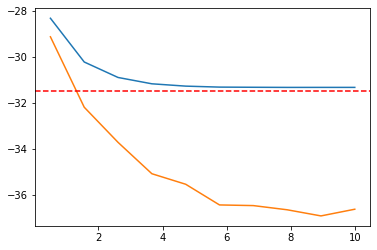

In [118]:
plt.plot(tfs,energies_clean)
plt.plot(tfs,energies_noerror_mitigation)
plt.axhline(y=-31.5,color='red',linestyle='--')
plt.show()